# HyperbolicTSNE

This notebook illustrates the usage of the HyperbolicTSNE library. Specifically, we load a subset of the MNIST dataset and embed it in hyperbolic space using the accelerated version of hyperbolic tsne. Finally, we save the embedding result as an image.

## Setup

First, we import the packages we will use and set important paths. Note that `hyperbolicTSNE.util` and `hyperbolicTSNE.visualization` contain useful functions for reading, processing and exporting embeddings.

In [13]:
import os
import traceback

from hyperbolicTSNE.util import find_last_embedding
from hyperbolicTSNE.visualization import plot_poincare, animate
from hyperbolicTSNE import load_data, Datasets, SequentialOptimizer, initialization, HyperbolicTSNE

In [14]:
data_home = "datasets"
log_path = "temp/poincare/"  # path for saving embedding snapshots

## Configure

HyperbolicTSNE follows a similar API to other TSNE libraries like OpenTSNE and sklearn. The configuration process consists of loading the data to embed and defining the settings of the embedder. We create a dict with parameters manually to demonstrate all the customization options. Nevertheless, `hyperbolicTSNE.hyperbolicTSNE` provides parameter templates to start with.

In [15]:
only_animate = False
seed = 42
dataset = Datasets.MNIST
num_points = 10000  # we use a subset for demonstration purposes, full MNIST has N=70000
perp = 30

dataX, dataY, D, V, _ = load_data(dataset, 
                                  data_home=data_home, 
                                  random_state=seed, 
                                  to_return="X_labels_D_V",
                                  hd_params={"perplexity": perp}, 
                                  sample=num_points, knn_method="hnswlib")

In [16]:
exag_factor = 12
learning_rate = (dataX.shape[0] * 1) / (exag_factor * 1000)
ex_iterations = 250
main_iterations = 750

opt_config = dict(
    learning_rate_ex=learning_rate,  # learning rate during exaggeration
    learning_rate_main=learning_rate,  # learning rate main optimization 
    exaggeration=exag_factor, 
    exaggeration_its=ex_iterations, 
    gradientDescent_its=main_iterations, 
    vanilla=False, 
    momentum_ex=0.5, 
    momentum=0.8, 
    exact=False, 
    grad_fix=False, 
    grad_scale_fix=False,
    n_iter_check=10,
    size_tol=0.999)

opt_params = SequentialOptimizer.sequence_poincare(**opt_config)

# Start: configure logging
logging_dict = {
    "log_path": log_path
}
opt_params["logging_dict"] = logging_dict

log_path = opt_params["logging_dict"]["log_path"]
# Delete old log path
if os.path.exists(log_path) and not only_animate:
    import shutil
    shutil.rmtree(log_path)
# End: logging

print(f"config: {opt_config}")

Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
config: {'learning_rate_ex': 0.8333333333333334, 'learning_rate_main': 0.8333333333333334, 'exaggeration': 12, 'exaggeration_its': 250, 'gradientDescent_its': 750, 'vanilla': False, 'momentum_ex': 0.5, 'momentum': 0.8, 'exact': False, 'grad_fix': False, 'grad_scale_fix': False, 'n_iter_check': 10, 'size_tol': 0.999}


## Run HyperbolicTSNE

Embedding the high dimensional data consists of three steps:
- Initializating the embedding
- Initializing the embedder 
- Embedding the data

The following three cells demonstrate this process. Note that use set metric to "precomputed" because we pass the distance matrix to the `fit` method.

In [17]:
X_embedded = initialization(n_samples=dataX.shape[0],
                            n_components=2,
                            X=dataX,
                            random_state=seed,
                            method="pca")

In [18]:
htsne = HyperbolicTSNE(init=X_embedded, 
                            n_components=2, 
                            metric="precomputed", 
                            verbose=True, 
                            opt_method=SequentialOptimizer, 
                            opt_params=opt_params)

In [19]:
try:
    res_hdeo_hyper = htsne.fit_transform((D, V))
except ValueError:
    res_hdeo_hyper = find_last_embedding(log_path)
    traceback.print_exc()

[HDEO] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
Running Gradient Descent, Verbosity: True
[gradient_descent] Warning: because of logging, the cf will be computed at every iteration


Gradient Descent:   0%|          | 0/250 [00:00<?, ?it/s]

Gradient Descent error: 97.19655 grad_norm: 6.60869e-01: 100%|██████████| 250/250 [01:11<00:00,  3.51it/s]


Running Gradient Descent, Verbosity: True
[gradient_descent] Warning: because of logging, the cf will be computed at every iteration


Gradient Descent error: 4.06912 grad_norm: 2.00660e-01:  39%|███▊      | 289/750 [01:14<01:58,  3.89it/s]

4


## Exporting and visualization

After running the embedding process, the embeddings arrays are saved to the `log_path`. We can use this information to visualize the embeddings using utility functions defined in `hyperbolicTSNE.visualization` as shown below.

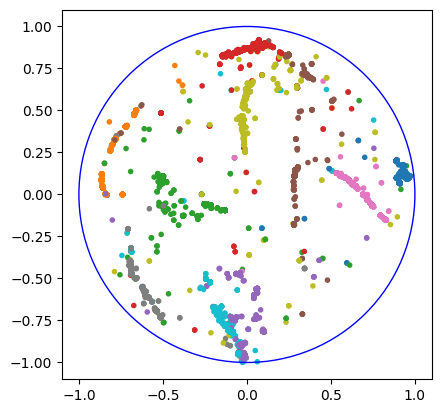

In [22]:
# save fig to file
fig = plot_poincare(res_hdeo_hyper, dataY)
fig.savefig(f"results/{dataset.name}-final.png")

In [24]:
animate(logging_dict, dataY, f"results/{dataset.name}_ani.mp4", fast=True, plot_ee=True)

Animation being saved to: results/MNIST_ani.mp4


Animating: : 57it [00:09,  6.02it/s]
